In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
# Carregamento do arquivo CSV em um DataFrame
# Ajuste o caminho e, se necessário, o separador (sep=';') e a codificação (encoding='latin-1')
CAMINHO = 'campeonato-brasileiro-full.csv'
df = pd.read_csv(CAMINHO, encoding='utf-8')

In [ ]:
# 3) Visualização das primeiras linhas do DataFrame
df.head()

In [ ]:
# Verificação de informações gerais
print(df.shape) # (linhas, colunas)
print(df.dtypes) # tipos de dados por coluna
df.info() # resumo (contagem de nulos, tipos, etc.)


# Valores nulos por coluna (visão rápida)
df.isna().sum()

(7645, 18)
ID                     int64
rodada                 int64
data                  object
hora                  object
dia                   object
mandante              object
visitante             object
formacao_mandante     object
formacao_visitante    object
tecnico_mandante      object
tecnico_visitante     object
vencedor              object
arena                 object
mandante_placar        int64
visitante_placar       int64
mandante_estado       object
visitante_estado      object
estado_vencedor       object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7645 entries, 0 to 7644
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  7645 non-null   int64 
 1   rodada              7645 non-null   int64 
 2   data                7645 non-null   object
 3   hora                7645 non-null   object
 4   dia                 7645 non-null   object
 5   manda

ID                       0
rodada                   0
data                     0
hora                     0
dia                      0
mandante                 0
visitante                0
formacao_mandante     4974
formacao_visitante    4974
tecnico_mandante      4610
tecnico_visitante     4610
vencedor                 0
arena                    0
mandante_placar          0
visitante_placar         0
mandante_estado          0
visitante_estado         0
estado_vencedor          0
dtype: int64

In [ ]:
# Estatísticas descritivas
# Numéricas
df.describe()


# Incluir categóricas
df.describe(include='all')

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
count,7645.000000,7645.000000,7645,7645,7645,7645,7645,2671,2671,3035,3035,7645,7645,7645.000000,7645.000000,7645,7645,7645
unique,NaN,NaN,1711,176,7,45,45,21,20,178,178,46,152,NaN,NaN,15,15,16
top,NaN,NaN,2021-11-11,16:00,Domingo,Fluminense,Flamengo,4-2-3-1,4-2-3-1,L. Venker de Menezes,L. Venker de Menezes,-,maracana,NaN,NaN,SP,SP,-
freq,NaN,NaN,27,1808,3561,371,372,1600,1525,100,100,2015,562,NaN,NaN,1907,1907,2015
mean,3823.000000,20.196207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.554088,1.027338,NaN,NaN,NaN
std,2207.065737,11.489249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.234262,1.030366,NaN,NaN,NaN
min,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,1912.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN
50%,3823.000000,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN
75%,5734.000000,30.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,NaN


In [ ]:
# Exemplo de imputação simples

# Colunas que queremos tratar
num_cols = ['mandante_placar', 'visitante_placar', 'rodada']
cat_cols = ['mandante_estado', 'visitante_estado', 'vencedor']

# Mantém só as colunas que realmente existem no DataFrame
num_cols = [c for c in num_cols if c in df.columns]
cat_cols = [c for c in cat_cols if c in df.columns]

# -------- Tratamento numérico --------
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')  # força numérico
    df[c] = df[c].fillna(df[c].median())           # preenche NaN com mediana

# -------- Tratamento categórico --------
for c in cat_cols:
    if df[c].isna().any():                         # se tiver nulos
        moda = df[c].mode(dropna=True)
        df[c] = df[c].fillna(moda.iloc[0] if len(moda) > 0 else 'Desconhecido')

In [ ]:
# Outliers por Z-Score (|z| > 3 por padrão)
threshold = 3.0
outlier_masks = []

for c in ['mandante_placar', 'visitante_placar']:
    if c in df.columns:
        # garante que a coluna seja numérica
        s = pd.to_numeric(df[c], errors='coerce')
        # calcula Z-Score ignorando NaN
        z = np.abs(stats.zscore(s, nan_policy='omit'))
        # alinhar índices (z retorna ndarray); criar Série com o mesmo index
        z = pd.Series(z, index=s.index)
        mask = z > threshold
        outlier_masks.append(mask)
        print(f"Outliers em {c}: {mask.sum()} linhas (threshold={threshold})")

# Combina máscaras de outliers (OU lógico)
if outlier_masks:
    outliers_mask = outlier_masks[0]
    for m in outlier_masks[1:]:
        outliers_mask = outliers_mask | m
else:
    outliers_mask = pd.Series(False, index=df.index)

# Cria DataFrames separados: apenas outliers e sem outliers
df_outliers = df[outliers_mask]
df_no_outliers = df[~outliers_mask].copy()

print("Tamanho do DataFrame com outliers:", df_outliers.shape)
print("Tamanho do DataFrame sem outliers:", df_no_outliers.shape)

Outliers em mandante_placar: 42 linhas (threshold=3.0)
Outliers em visitante_placar: 30 linhas (threshold=3.0)
Tamanho do DataFrame com outliers: (72, 18)
Tamanho do DataFrame sem outliers: (7573, 18)


In [ ]:
# Winsorizar (aparar extremos) nas colunas de placar
for c in ['mandante_placar', 'visitante_placar']:
    if c in df.columns:
        # calcula os quantis de 1% e 99%
        low, high = df[c].quantile([0.01, 0.99])
        # aparar os valores abaixo/above dos quantis
        df[c] = df[c].clip(lower=low, upper=high)


In [ ]:
# Normalização Min–Max em uma coluna numérica (ex.: rodada)
if 'rodada' in df.columns:
    rmin, rmax = df['rodada'].min(), df['rodada'].max()
    if rmax > rmin:
        df['rodada_minmax'] = (df['rodada'] - rmin) / (rmax - rmin)

In [ ]:
# One-Hot Encoding (dummies)
cols_categoricas = [c for c in ['mandante_estado', 'visitante_estado', 'vencedor'] if c in df.columns]


df_encoded = pd.get_dummies(df, columns=cols_categoricas, drop_first=False, dtype=int)
df_encoded.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,...,vencedor_Ponte Preta,vencedor_Portuguesa,vencedor_Santa Cruz,vencedor_Santo Andre,vencedor_Santos,vencedor_Sao Caetano,vencedor_Sao Paulo,vencedor_Sport,vencedor_Vasco,vencedor_Vitoria
0,1,1,2003-03-29,16:00,Sabado,Guarani,Vasco,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2,1,2003-03-29,16:00,Sabado,Athletico-PR,Gremio,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,3,1,2003-03-30,16:00,Domingo,Flamengo,Coritiba,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,4,1,2003-03-30,16:00,Domingo,Goias,Paysandu,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,5,1,2003-03-30,16:00,Domingo,Internacional,Ponte Preta,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


                  mandante_placar  visitante_placar    rodada
mandante_placar          1.000000          0.054316  0.031449
visitante_placar         0.054316          1.000000  0.000632
rodada                   0.031449          0.000632  1.000000


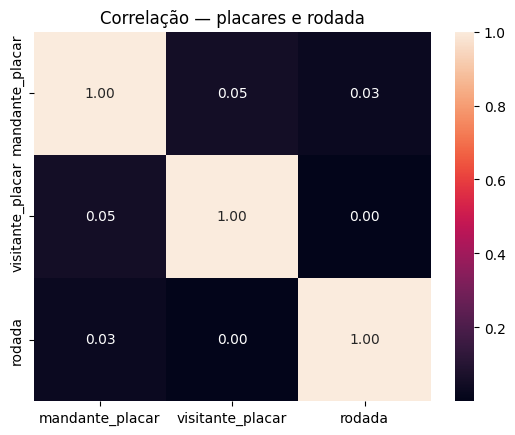

In [ ]:
# Correlação focando em placares e rodada
cols_corr = [c for c in ['mandante_placar', 'visitante_placar', 'rodada', 'dif_gols'] if c in df_encoded.columns]


corr = df_encoded[cols_corr].corr()
print(corr)


# (Opcional) Heatmap rápido
sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Correlação — placares e rodada')
plt.show()

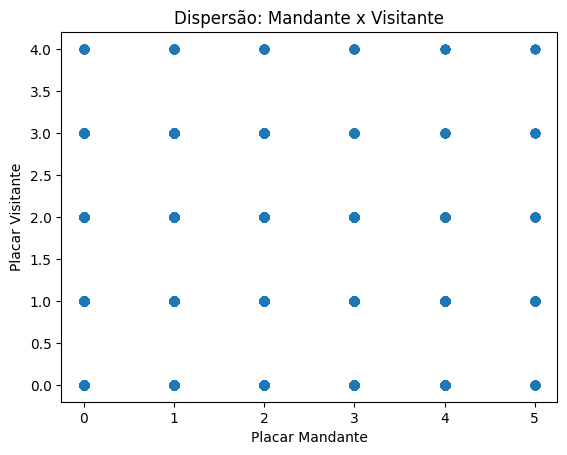

In [ ]:
# Dispersão dos placares
if set(['mandante_placar', 'visitante_placar']).issubset(df_encoded.columns):
    plt.scatter(df_encoded['mandante_placar'], df_encoded['visitante_placar'])
    plt.xlabel('Placar Mandante')
    plt.ylabel('Placar Visitante')
    plt.title('Dispersão: Mandante x Visitante')
    plt.show()


In [ ]:
# Filtragem
col_time_mandante = 'mandante' if 'mandante' in df.columns else (
    'mandante_time' if 'mandante_time' in df.columns else None
)

if col_time_mandante is not None:
    flamengo_casa = df[df[col_time_mandante].str.lower() == 'flamengo']
    flamengo_casa.head()
else:
    print('Ajuste o nome da coluna do time mandante em col_time_mandante.')


In [ ]:
# Exportação para CSV
ARQ_SAIDA = 'dados_processados.csv'
df_encoded.to_csv(ARQ_SAIDA, index=False)
print(f'Arquivo salvo em: {ARQ_SAIDA}')

Arquivo salvo em: dados_processados.csv


In [ ]:
# Datas -> datetime; extrair ano e mês
if 'data' in df.columns:
    df['data'] = pd.to_datetime(df['data'], errors='coerce', dayfirst=True)
    df['ano'] = df['data'].dt.year
    df['mes'] = df['data'].dt.month

# Se desejar, refaça df_encoded após criar novas colunas
df_encoded = pd.get_dummies(
    df, 
    columns=[c for c in ['mandante_estado', 'visitante_estado', 'vencedor'] if c in df.columns],
    drop_first=False, 
    dtype=int
)


In [ ]:
# agrupamento dos dados
if 'vencedor' in df.columns and 'mandante_estado' in df.columns:
    vitórias_estado = df.groupby('mandante_estado')['vencedor'].apply(lambda x: (x == 'Mandante').sum())
    print(vitórias_estado.sort_values(ascending=False))

mandante_estado
AL    0
BA    0
CE    0
DF    0
GO    0
MG    0
MT    0
PA    0
PE    0
PR    0
RJ    0
RN    0
RS    0
SC    0
SP    0
Name: vencedor, dtype: int64


In [ ]:
# coluna derivada
if all(c in df.columns for c in ['mandante_placar', 'visitante_placar']):
    df['dif_gols'] = df['mandante_placar'] - df['visitante_placar']

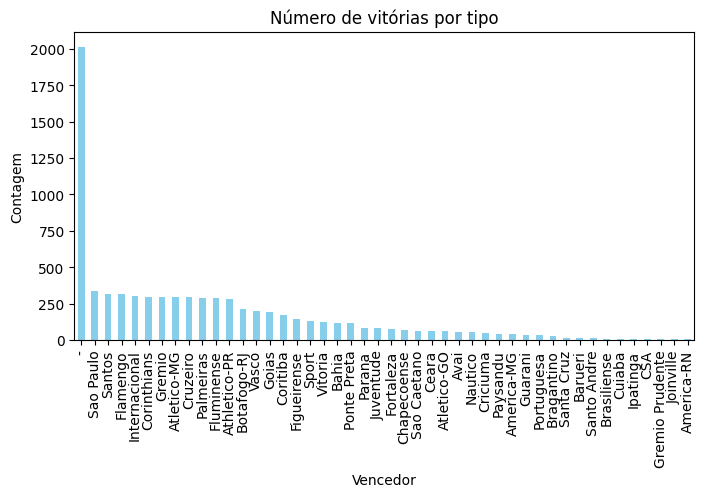

In [ ]:
# vizualização do grafico
if 'vencedor' in df.columns:
    plt.figure(figsize=(8,4))
    df['vencedor'].value_counts().plot(kind='bar', color='skyblue')
    plt.title('Número de vitórias por tipo')
    plt.xlabel('Vencedor')
    plt.ylabel('Contagem')
    plt.show()

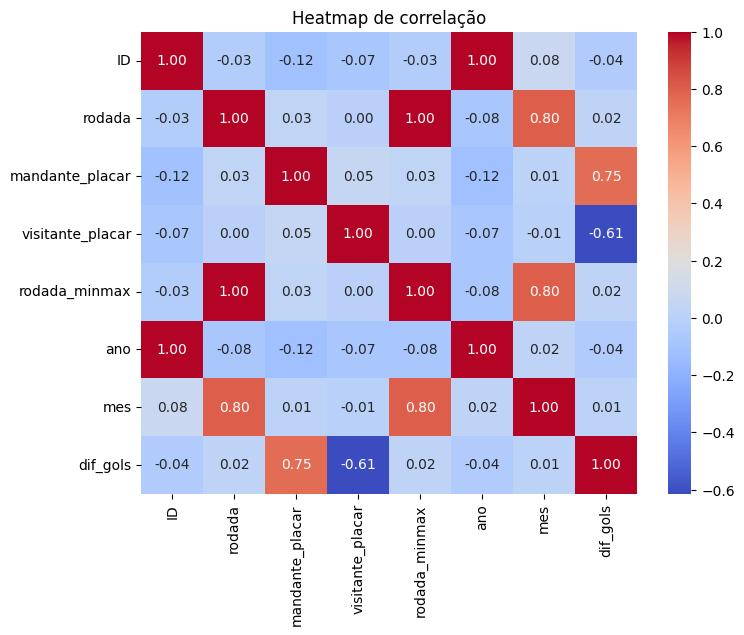

In [ ]:
# heatmap
corr_cols = df.select_dtypes(include=np.number).columns.tolist()
if corr_cols:
    plt.figure(figsize=(8,6))
    sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Heatmap de correlação')
    plt.show()